Model Type: ViT + SVM hybrid

Feature Extractor: Vision Transformer (ViT-Base-Patch16-224)

Classifier: Linear Support Vector Machine (SVM)

Input: RGB images resized to 224×224 px

Classes: 10 pest species (Aphid, Armyworm, Beetle, Bollworm, Grasshopper, Locust, Mealybug, Stemborer, Weevil, Whitefly)

Dataset Size: 10,457 images (1K per class)

Train/Test Split: 80% / 20%

Training Time: ~5 seconds

Inference Speed: ~1.12 ms per image

Performance: Accuracy = 91.35%, Weighted F1-score = 0.9135

Outputs Saved:

vit_svm_classifier_pest.joblib → trained SVM

feature_extractor/ → ViT feature extractor

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing class aphids (1051 images)
Saved features for aphids
Processing class army worm (1079 images)
Saved features for army worm
Processing class ballwarm (1018 images)
Saved features for ballwarm
Processing class beetle (1031 images)
Saved features for beetle
Processing class grasshopper (1025 images)
Saved features for grasshopper
Processing class mites (1039 images)
Saved features for mites
Processing class red spider (1044 images)
Saved features for red spider
Processing class sawfly (1080 images)
Saved features for sawfly
Processing class stem borer (1008 images)
Saved features for stem borer
Processing class whitefly (1082 images)
Saved features for whitefly
Total samples: 10457
Training SVM...
Training time: 4.99 seconds
Accuracy: 91.35%
F1 Score: 0.9135
Inference speed: 1.12 ms/image
SVM saved as vit_svm_classifier_pest.joblib


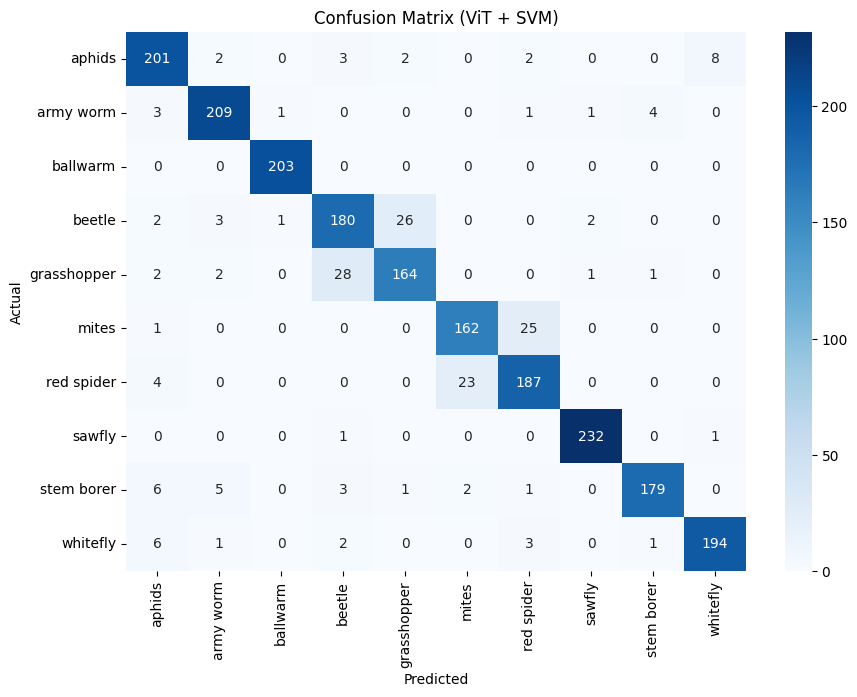

In [ ]:
import os
import torch
import numpy as np
import joblib
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
dataset_path = "/content/drive/MyDrive/Pests_dataset ORIGINAL/Dataset"  # Update as needed
classes = sorted(os.listdir(dataset_path))

# Load ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
vit_model.eval()

# Preprocess a single image
def transform_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = feature_extractor(images=img, return_tensors="pt")['pixel_values'].to(device)
    return img

# Extract features in batches
def extract_features_batch(image_paths, batch_size=16):
    all_features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = [transform_image(p) for p in batch_paths]
        batch_tensor = torch.cat(batch_imgs, dim=0)
        with torch.no_grad():
            features = vit_model(batch_tensor).last_hidden_state[:, 0, :]
        all_features.append(features.cpu().numpy())
    return np.vstack(all_features)

# ----------------------------------------------------------------------
# Feature extraction with incremental saving
# ----------------------------------------------------------------------
X_list, y_list = [], []

for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_folder):
        continue

    image_paths = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]
    print(f"Processing class {class_name} ({len(image_paths)} images)")

    # Batch extraction
    features = extract_features_batch(image_paths, batch_size=16)
    labels = np.full(len(features), class_idx)

    # Append to disk-friendly lists
    X_list.append(features)
    y_list.append(labels)

    # Optional: Save each class features immediately
    joblib.dump((features, labels), f"features_{class_name}.joblib")
    print(f"Saved features for {class_name}")

# Concatenate all features after processing
X = np.vstack(X_list)
y = np.hstack(y_list)
print(f"Total samples: {len(X)}")

# ----------------------------------------------------------------------
# Train/Test split and SVM
# ----------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear', random_state=42)
print("Training SVM...")
start_time = time.time()
svm_classifier.fit(X_train, y_train)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# Evaluation
start_time = time.time()
y_pred = svm_classifier.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test) * 1000  # ms/image

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Inference speed: {inference_time:.2f} ms/image")

# Save final SVM
joblib.dump(svm_classifier, "vit_svm_classifier_pest.joblib")
print("SVM saved as vit_svm_classifier_pest.joblib")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (ViT + SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
